In [1]:
# Basic imports
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
from imageio import imread
from pathlib import Path

# Library imports
from multiview_prediction_toolkit.cameras.derived_cameras import MetashapeCameraSet
from multiview_prediction_toolkit.meshes import TexturedPhotogrammetryMesh
from multiview_prediction_toolkit.utils.geospatial import ensure_geometric_CRS
from multiview_prediction_toolkit.config import (
    DATA_FOLDER,
    EXAMPLE_LABELS_FILENAME,
    EXAMPLE_MESH_FILENAME,
    EXAMPLE_CAMERAS_FILENAME,
    EXAMPLE_DTM_FILE,
    EXAMPLE_IMAGE_FOLDER,
    EXAMPLE_STANDARDIZED_LABELS_FILENAME,
    EXAMPLE_LABELED_MESH_FILENAME,
    EXAMPLE_RENDERED_LABELS_FOLDER,
    NULL_TEXTURE_INT_VALUE,
)

/ofo-share/repos-david/conda/envs/MVMT-stable/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Set constants
You should be able to define most of the behavior from these constants

In [2]:
## Parameters to control the outputs
# Repeat the labeling process
RETEXTURE = True
# Points less than this height above the DTM are considered ground
# Something is off about the elevation between the mesh and the DTM, this should be a threshold in meters above ground
HEIGHT_ABOVE_GROUND_THRESH = 34666.83516999893 + 5
# The image is downsampled to this fraction for accelerated rendering
RENDER_IMAGE_SCALE = 0.25
# Cameras within this distance of the traing data are used in the rendering process
BUFFER_RADIUS_METER = 50
# Tree Radius
TREE_RADIUS_METERS = 2.5
# Downsample target
DOWNSAMPLE_TARGET = 0.1

## Define the inputs
# The input labels
LABELS_FILENAME = EXAMPLE_LABELS_FILENAME
# The mesh exported from Metashape
MESH_FILENAME = EXAMPLE_MESH_FILENAME
# The camera file exported from Metashape
CAMERAS_FILENAME = EXAMPLE_CAMERAS_FILENAME
# The digital elevation map exported by Metashape
DTM_FILE = EXAMPLE_DTM_FILE
# The image folder used to create the Metashape project
IMAGE_FOLDER = EXAMPLE_IMAGE_FOLDER

## Define the intermediate results
# Processed geo file
STANDARDIZED_LABELS_FILENAME = EXAMPLE_STANDARDIZED_LABELS_FILENAME
# Where to save the mesh after labeling
LABELED_MESH_FILENAME = EXAMPLE_LABELED_MESH_FILENAME
# Where to save the rendering label images
RENDER_FOLDER = EXAMPLE_RENDERED_LABELS_FOLDER

# Geospatial processing

Preprocess the geospatial data to be as expected.

<Axes: >

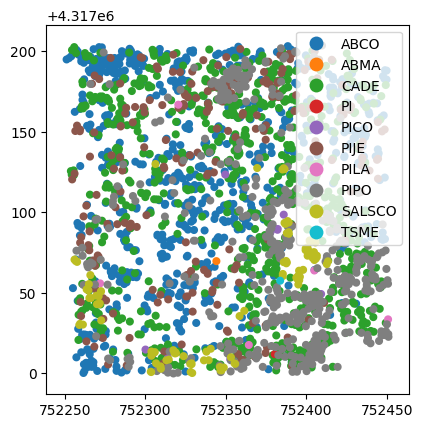

In [3]:
# Load the data
gdf = gpd.read_file(LABELS_FILENAME)
# Ensure that the CRS is geometric so we can buffer
gdf = ensure_geometric_CRS(gdf)

# Now create circles around each point
gdf["geometry"] = gdf["geometry"].buffer(TREE_RADIUS_METERS)

# Split
gdf = gdf.dissolve("Species", as_index=False)
# Drop all but the geometry and the species label
gdf = gdf.loc[:, gdf.columns.intersection(["Species", "geometry"])]
# Write out the sandarized file
gdf.to_file(STANDARDIZED_LABELS_FILENAME)
# Show
gdf.plot("Species", legend=True)

# Load the mesh and read texture from geopolygon

In [4]:
# Create a labeled version of the mesh from the field data
# if not present or requested
if not Path(LABELED_MESH_FILENAME).is_file() or RETEXTURE:
    # Load the downsampled mesh and apply the texture from the vector file
    mesh = TexturedPhotogrammetryMesh(
        MESH_FILENAME,
        downsample_target=DOWNSAMPLE_TARGET,
        texture=STANDARDIZED_LABELS_FILENAME,
        texture_kwargs={"column_name": "Species"},
        transform_filename=CAMERAS_FILENAME,
    )
    # Get the vertex textures from the mesh
    texture_verts = mesh.get_texture(
        request_vertex_texture=True, try_verts_faces_conversion=False
    )
    # Compute which vertices are part of the ground by thresholding the height above the DTM
    ground_mask_verts = mesh.get_height_above_ground(
        DTM_file=DTM_FILE, threshold=HEIGHT_ABOVE_GROUND_THRESH
    )

    # Find which vertices are labeled
    is_labeled = texture_verts[:, 0] >= 0
    # Find which points are ground that were previously labeled as something else
    is_labeled_and_ground = np.logical_and(is_labeled, ground_mask_verts)

    # Update label names
    label_names = mesh.get_label_names()
    mesh.set_label_names(label_names.tolist() + ["GROUND"])

    # Set a new ground class only for ground that would otherwise be tree
    texture_verts[is_labeled_and_ground, 0] = len(label_names)
    # Apply the texture to the mesh
    mesh.set_texture(texture_verts)

    mesh.save_mesh(LABELED_MESH_FILENAME, save_vert_texture=True)
else:
    mesh = TexturedPhotogrammetryMesh(
        LABELED_MESH_FILENAME, transform_filename=CAMERAS_FILENAME
    )

Sampling values from raster: 100%|██████████| 71620/71620 [00:00<00:00, 603761.40it/s]


# Load a set of cameras and downsample them to the region around annotations

Loading GPS data for camera set: 100%|██████████| 915/915 [00:00<00:00, 1408879.65it/s]
/ofo-share/repos-david/conda/envs/MVMT-stable/lib/python3.9/site-packages/pyvista/plotting/plotter.py:149: UserWarning: 
This system does not appear to be running an xserver.
PyVista will likely segfault when rendering.

Try starting a virtual frame buffer with xvfb, or using
  ``pyvista.start_xvfb()``

  warnings.warn(
/ofo-share/repos-david/conda/envs/MVMT-stable/lib/python3.9/site-packages/pyvista/jupyter/notebook.py:33: UserWarning: Failed to use notebook backend: 

No module named 'trame.ui.vuetify'

Falling back to a static output.
  warnings.warn(


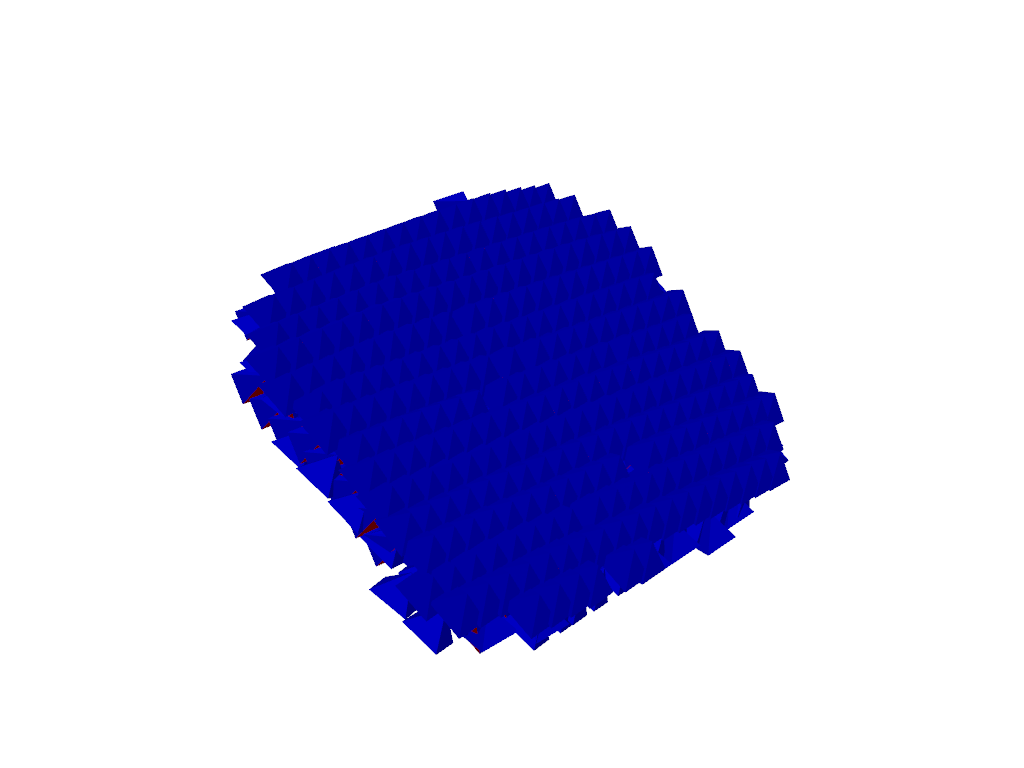

In [5]:
# Create camera set
camera_set = MetashapeCameraSet(CAMERAS_FILENAME, IMAGE_FOLDER)
# Extract cameras near the training data
training_camera_set = camera_set.get_subset_near_geofile(
    STANDARDIZED_LABELS_FILENAME, buffer_radius_meters=BUFFER_RADIUS_METER
)
training_camera_set.vis(force_xvfb=True, frustum_scale=0.5)

# Show the mesh

/ofo-share/repos-david/conda/envs/MVMT-stable/lib/python3.9/site-packages/pyvista/jupyter/notebook.py:33: UserWarning: Failed to use notebook backend: 

No module named 'trame.ui.vuetify'

Falling back to a static output.
  warnings.warn(


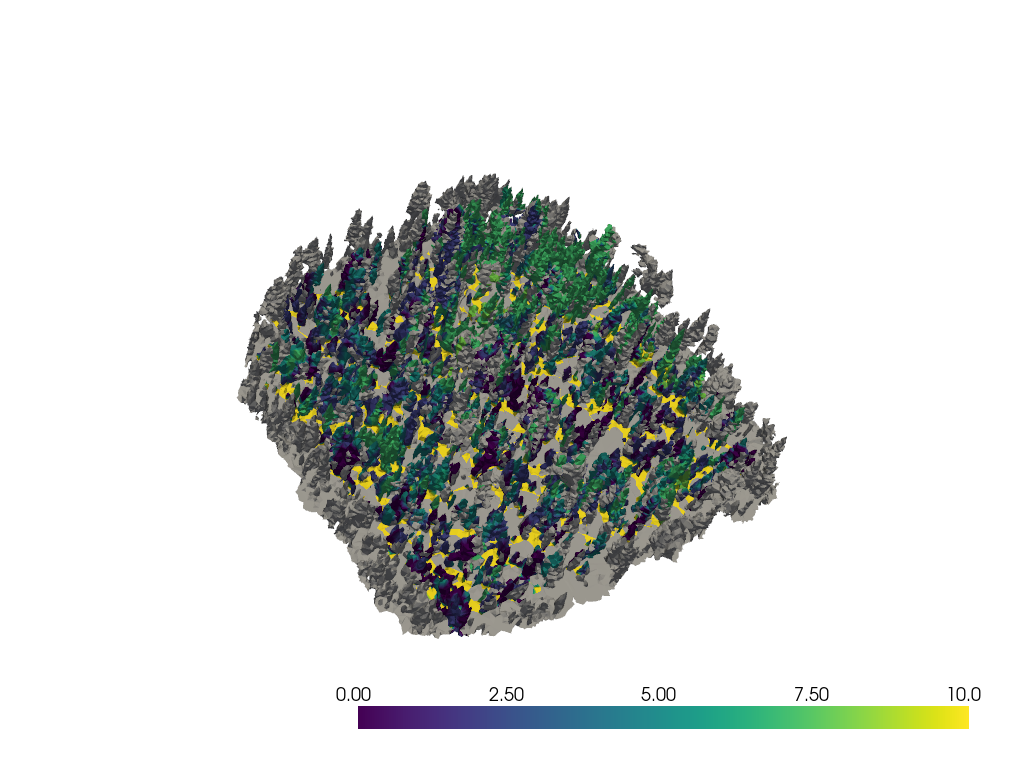

In [6]:
# You can include the camera set, but it's cleaner without it
mesh.vis(camera_set=None, force_xvfb=True, mesh_kwargs={"clim":[0,10], "cmap":"tab10"})

# Render the labels onto the images

In [7]:
mesh.save_renders_pytorch3d(
    camera_set=training_camera_set,
    render_image_scale=RENDER_IMAGE_SCALE,
    save_native_resolution=True,
    output_folder=RENDER_FOLDER,
)

Saving renders: 100%|██████████| 778/778 [06:11<00:00,  2.10it/s]


# Show some of the rendered labels

/tmp/ipykernel_34751/1497803898.py:11: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imread(image_file)
/tmp/ipykernel_34751/1497803898.py:12: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  render = imread(rendered_file).astype(float)


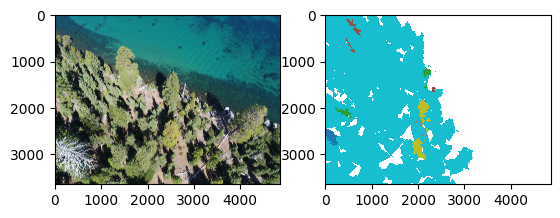

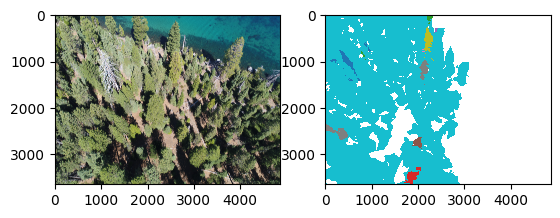

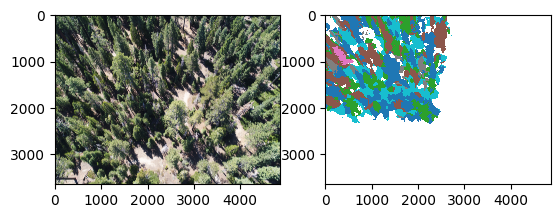

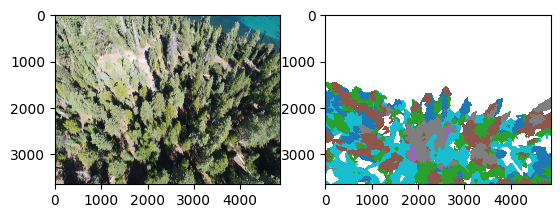

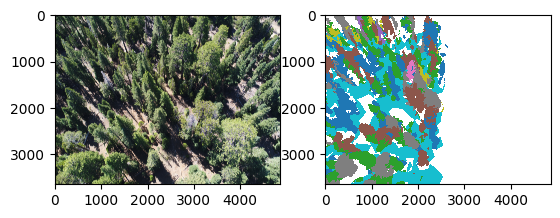

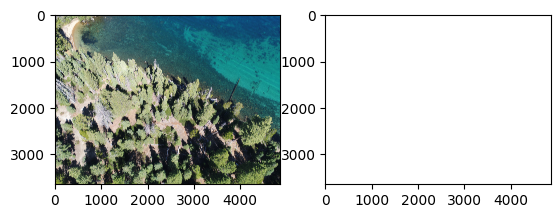

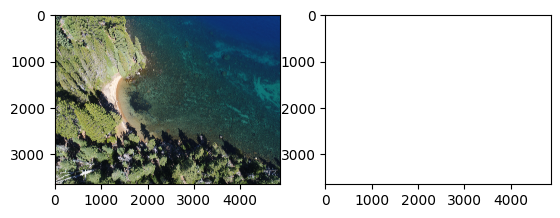

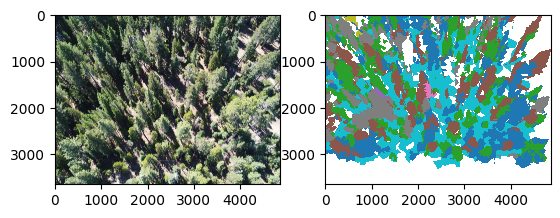

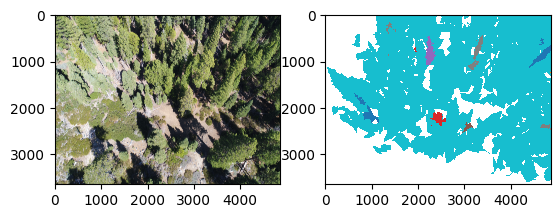

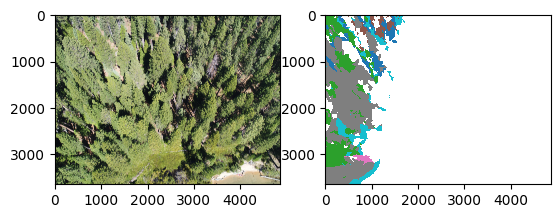

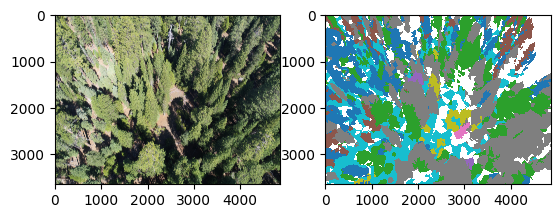

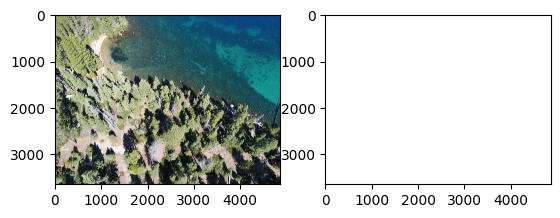

KeyboardInterrupt: 

In [10]:
rendered_files = list(Path(RENDER_FOLDER).rglob("*.png"))

for rendered_file in rendered_files[:40]:
    image_file = Path(
        IMAGE_FOLDER, rendered_file.relative_to(RENDER_FOLDER)
    ).with_suffix(".JPG")
    image = imread(image_file)
    render = imread(rendered_file).astype(float)
    render[render == NULL_TEXTURE_INT_VALUE] = np.nan
    f, ax = plt.subplots(1, 2)
    ax[0].imshow(image)
    ax[1].imshow(render, vmin=0, vmax=10, cmap="tab10", interpolation="none")
    plt.show()
    plt.close()